In [14]:
import camelot
import pandas as pd
import numpy as np
from IPython.display import display
import os
from pathlib import Path
import ocrmypdf

In [15]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv

try:
    from PIL import Image
except ImportError:
    import Image

import pytesseract
from pdf2image import convert_from_path
import xlsxwriter

In [16]:
input_path_to_a = Path('data/a.pdf')
images_path = 'process_data/a_images/'

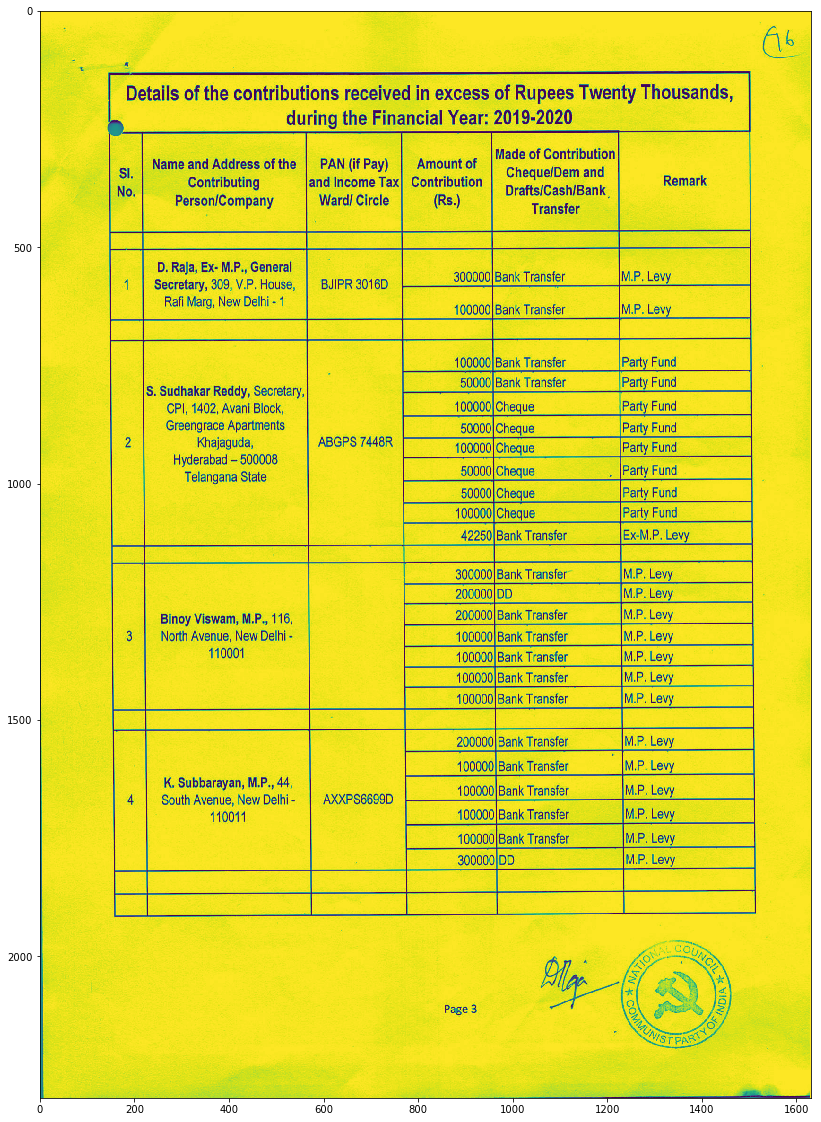

In [28]:
#read your file
file = images_path+'0.png'
img = cv2.imread(str(file),0)
# img = cv2.GaussianBlur(img, (5, 5), 0)
# img = cv2.Canny(img, 75, 200)
plt.figure(figsize = (40,20))
plotting = plt.imshow(img)
plt.show()

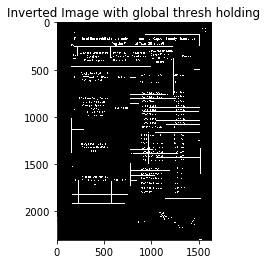

In [29]:
thresh,img_bin = cv2.threshold(img,128,255,cv2.THRESH_BINARY)
img_bin = 255-img_bin
plotting = plt.imshow(img_bin,cmap='gray')
plt.title("Inverted Image with global thresh holding")
plt.show()

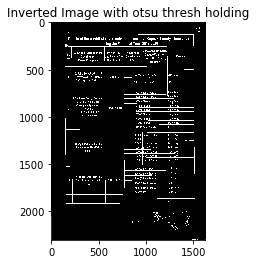

In [30]:
img_bin1 = 255-img
thresh1,img_bin1_otsu = cv2.threshold(img_bin1,128,255,cv2.THRESH_OTSU)
plotting = plt.imshow(img_bin1_otsu,cmap='gray')
plt.title("Inverted Image with otsu thresh holding")
plt.show()

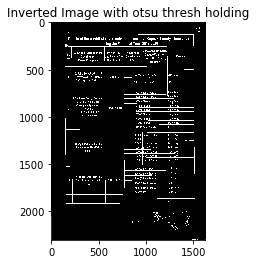

In [32]:
img_bin2 = 255-img
# thresh,img_bin = cv2.threshold(img,128,255,cv2.THRESH_BINARY |cv2.THRESH_OTSU)
thresh1,img_bin_otsu = cv2.threshold(img_bin2,128,255,cv2.THRESH_BINARY |cv2.THRESH_OTSU)
plotting = plt.imshow(img_bin_otsu,cmap='gray')
plt.title("Inverted Image with otsu thresh holding")
plt.show()

In [33]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

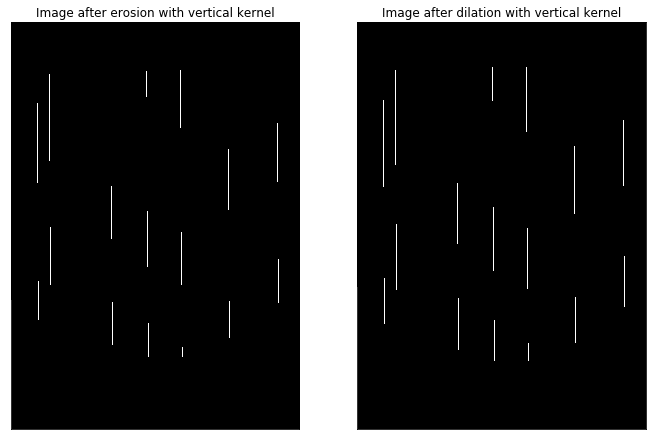

In [35]:
plt.figure(figsize= (30,30))

vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, np.array(img).shape[1]//100))
eroded_image = cv2.erode(img_bin_otsu, vertical_kernel, iterations=3)
plt.subplot(151),plt.imshow(eroded_image, cmap = 'gray')
plt.title('Image after erosion with vertical kernel'), plt.xticks([]), plt.yticks([])

vertical_lines = cv2.dilate(eroded_image, vertical_kernel, iterations=3)
plt.subplot(152),plt.imshow(vertical_lines, cmap = 'gray')
plt.title('Image after dilation with vertical kernel'), plt.xticks([]), plt.yticks([])

plt.show()

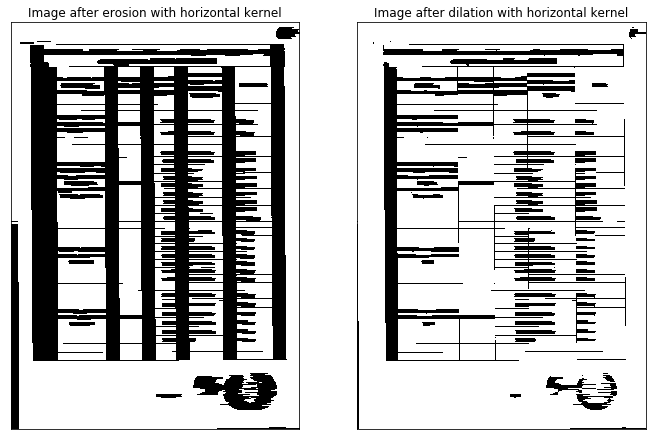

In [37]:
plt.figure(figsize= (30,30))

hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (np.array(img).shape[1]//100, 1))
horizontal_lines = cv2.erode(img_bin, hor_kernel, iterations=5)
plt.subplot(153),plt.imshow(horizontal_lines, cmap = 'gray')
plt.title('Image after erosion with horizontal kernel'), plt.xticks([]), plt.yticks([])

horizontal_lines = cv2.dilate(horizontal_lines, hor_kernel, iterations=5)
plt.subplot(154),plt.imshow(horizontal_lines, cmap = 'gray')
plt.title('Image after dilation with horizontal kernel'), plt.xticks([]), plt.yticks([])

plt.show()

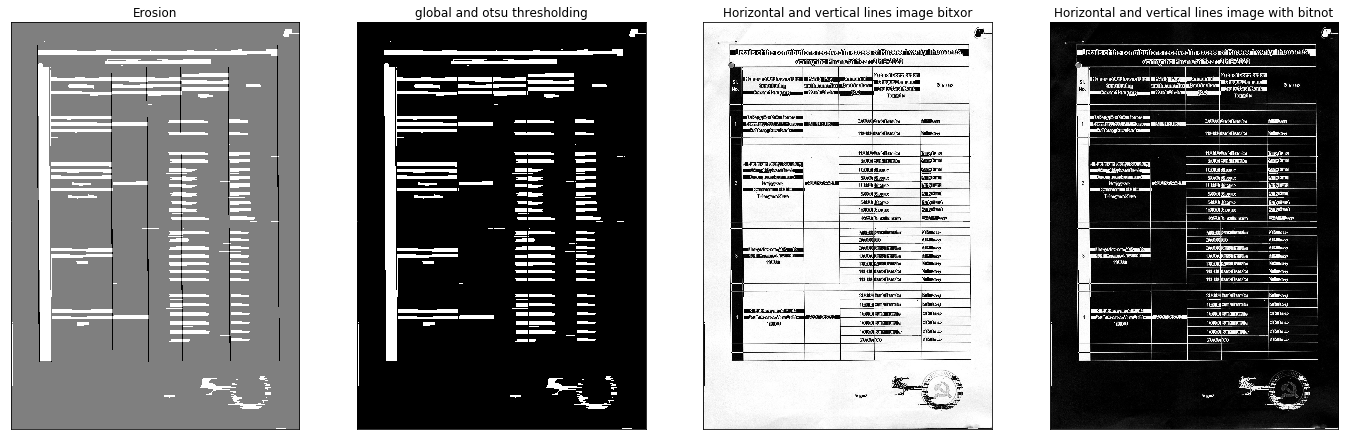

In [38]:
plt.figure(figsize= (30,30))

vertical_horizontal_lines = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)
vertical_horizontal_lines = cv2.erode(~vertical_horizontal_lines, kernel, iterations=3)
plt.subplot(151),plt.imshow(vertical_horizontal_lines, cmap = 'gray')
plt.title('Erosion'), plt.xticks([]), plt.yticks([])

thresh, vertical_horizontal_lines = cv2.threshold(vertical_horizontal_lines,128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
plt.subplot(152),plt.imshow(vertical_horizontal_lines, cmap = 'gray')
plt.title('global and otsu thresholding'), plt.xticks([]), plt.yticks([])

bitxor = cv2.bitwise_xor(img,vertical_horizontal_lines)
plt.subplot(153),plt.imshow(bitxor, cmap = 'gray')
plt.title('Horizontal and vertical lines image bitxor'), plt.xticks([]), plt.yticks([])

bitnot = cv2.bitwise_not(bitxor)
plt.subplot(154),plt.imshow(bitnot, cmap = 'gray')
plt.title('Horizontal and vertical lines image with bitnot'), plt.xticks([]), plt.yticks([])

plt.show()

In [39]:
contours, hierarchy = cv2.findContours(vertical_horizontal_lines, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [40]:
boundingBoxes = [cv2.boundingRect(contour) for contour in contours]
(contours, boundingBoxes) = zip(*sorted(zip(contours, boundingBoxes),key=lambda x:x[1][1]))

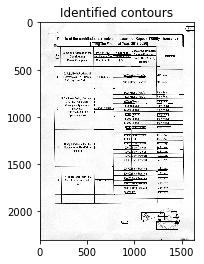

In [41]:
boxes = []
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    if (w<1000 and h<500):
        image = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
        boxes.append([x,y,w,h])
plotting = plt.imshow(image,cmap='gray')
plt.title("Identified contours")
plt.show()

In [42]:


rows=[]
columns=[]
heights = [boundingBoxes[i][3] for i in range(len(boundingBoxes))]
mean = np.mean(heights)
print(mean)
columns.append(boxes[0])
previous=boxes[0]
for i in range(1,len(boxes)):
    if(boxes[i][1]<=previous[1]+mean/2):
        columns.append(boxes[i])
        previous=boxes[i]
    if(i==len(boxes)-1):
        rows.append(columns)
    else:
        rows.append(columns)
        columns=[]
        previous = boxes[i]
        columns.append(boxes[i])
print("Rows")
for row in rows:
    print(row)

27.8125
Rows
[[1558, 37, 1, 1], [1537, 46, 94, 42]]
[[1537, 46, 94, 42]]
[[188, 113, 3, 5]]
[[1506, 133, 3, 124]]
[[1157, 162, 85, 7]]
[[530, 213, 600, 39], [544, 217, 108, 7]]
[[544, 217, 108, 7]]
[[1228, 257, 2, 2], [960, 257, 263, 4]]
[[960, 257, 263, 4], [769, 258, 186, 3]]
[[769, 258, 186, 3], [567, 259, 197, 3]]
[[567, 259, 197, 3]]
[[1228, 295, 2, 20], [960, 295, 263, 59]]
[[960, 295, 263, 59]]
[[769, 315, 186, 28], [568, 316, 196, 27]]
[[568, 316, 196, 27]]
[[1228, 334, 2, 20]]
[[1328, 353, 86, 19], [960, 354, 263, 65]]
[[960, 354, 263, 65], [769, 354, 186, 21]]
[[769, 354, 186, 21], [570, 355, 194, 20]]
[[570, 355, 194, 20], [322, 355, 147, 26]]
[[322, 355, 147, 26]]
[[1229, 372, 2, 20]]
[[770, 393, 185, 27], [568, 393, 196, 25]]
[[568, 393, 196, 25]]
[[1049, 411, 97, 21]]
[[1231, 468, 29, 1], [963, 469, 102, 1]]
[[963, 469, 102, 1], [772, 470, 25, 1]]
[[772, 470, 25, 1]]
[[568, 507, 7, 1], [560, 507, 3, 1]]
[[560, 507, 3, 1]]
[[569, 535, 2, 18]]
[[1232, 555, 107, 18], [961, 5

In [43]:
total_cells=0
for i in range(len(row)):
    if len(row[i]) > total_cells:
        total_cells = len(row[i])
print(total_cells)

4


In [44]:
center = [int(rows[i][j][0]+rows[i][j][2]/2) for j in range(len(rows[i])) if rows[0]]
print(center)

[1558, 1584]


In [45]:
center=np.array(center)
center.sort()
print(center)

[1558 1584]


In [46]:
boxes_list = []
for i in range(len(rows)):
    l=[]
    for k in range(total_cells):
        l.append([])
    for j in range(len(rows[i])):
        diff = abs(center-(rows[i][j][0]+rows[i][j][2]/4))
        minimum = min(diff)
        indexing = list(diff).index(minimum)
        l[indexing].append(rows[i][j])
    boxes_list.append(l)
for box in boxes_list:
    print(box)

[[[1558, 37, 1, 1], [1537, 46, 94, 42]], [], [], []]
[[[1537, 46, 94, 42]], [], [], []]
[[[188, 113, 3, 5]], [], [], []]
[[[1506, 133, 3, 124]], [], [], []]
[[[1157, 162, 85, 7]], [], [], []]
[[[530, 213, 600, 39], [544, 217, 108, 7]], [], [], []]
[[[544, 217, 108, 7]], [], [], []]
[[[1228, 257, 2, 2], [960, 257, 263, 4]], [], [], []]
[[[960, 257, 263, 4], [769, 258, 186, 3]], [], [], []]
[[[769, 258, 186, 3], [567, 259, 197, 3]], [], [], []]
[[[567, 259, 197, 3]], [], [], []]
[[[1228, 295, 2, 20], [960, 295, 263, 59]], [], [], []]
[[[960, 295, 263, 59]], [], [], []]
[[[769, 315, 186, 28], [568, 316, 196, 27]], [], [], []]
[[[568, 316, 196, 27]], [], [], []]
[[[1228, 334, 2, 20]], [], [], []]
[[[1328, 353, 86, 19], [960, 354, 263, 65]], [], [], []]
[[[960, 354, 263, 65], [769, 354, 186, 21]], [], [], []]
[[[769, 354, 186, 21], [570, 355, 194, 20]], [], [], []]
[[[570, 355, 194, 20], [322, 355, 147, 26]], [], [], []]
[[[322, 355, 147, 26]], [], [], []]
[[[1229, 372, 2, 20]], [], [], []]

In [47]:
dataframe_final=[]
for i in range(len(boxes_list)):
    for j in range(len(boxes_list[i])):
        s=''
        if(len(boxes_list[i][j])==0):
            dataframe_final.append(' ')
        else:
            for k in range(len(boxes_list[i][j])):
                y,x,w,h = boxes_list[i][j][k][0],boxes_list[i][j][k][1], boxes_list[i][j][k][2],boxes_list[i][j][k][3]
                roi = bitnot[x:x+h, y:y+w]
                kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
                border = cv2.copyMakeBorder(roi,2,2,2,2, cv2.BORDER_CONSTANT,value=[255,255])
                resizing = cv2.resize(border, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
                dilation = cv2.dilate(resizing, kernel,iterations=1)
                erosion = cv2.erode(dilation, kernel,iterations=2)                
                out = pytesseract.image_to_string(erosion)
                if(len(out)==0):
                    out = pytesseract.image_to_string(erosion)
                s = s +" "+ out
            dataframe_final.append(s)
print(dataframe_final)

[' \x0c \x0c', ' ', ' ', ' ', ' \x0c', ' ', ' ', ' ', ' \x0c', ' ', ' ', ' ', ' \x0c', ' ', ' ', ' ', ' \x0c', ' ', ' ', ' ', '  \n\x0c \x0c', ' ', ' ', ' ', ' \x0c', ' ', ' ', ' ', ' \x0c \x0c', ' ', ' ', ' ', ' \x0c \x0c', ' ', ' ', ' ', ' \x0c \x0c', ' ', ' ', ' ', ' \x0c', ' ', ' ', ' ', ' \x0c ‘Co\neaueé.\n\x0c', ' ', ' ', ' ', ' ‘Co\neaueé.\n\x0c', ' ', ' ', ' ', ' \x0c \x0c', ' ', ' ', ' ', ' \x0c', ' ', ' ', ' ', ' \x0c', ' ', ' ', ' ', ' \x0c ra\n\x0c', ' ', ' ', ' ', ' ra\n\x0c \x0c', ' ', ' ', ' ', ' \x0c \x0c', ' ', ' ', ' ', ' \x0c \x0c', ' ', ' ', ' ', ' \x0c', ' ', ' ', ' ', ' \x0c', ' ', ' ', ' ', " \x0c '_Ward/ Circl\n\x0c", ' ', ' ', ' ', " '_Ward/ Circl\n\x0c", ' ', ' ', ' ', ' \x0c', ' ', ' ', ' ', ' \x0c \x0c', ' ', ' ', ' ', ' \x0c \x0c', ' ', ' ', ' ', ' \x0c', ' ', ' ', ' ', ' \x0c \x0c', ' ', ' ', ' ', ' \x0c', ' ', ' ', ' ', ' \x0c', ' ', ' ', ' ', ' \x0c \x0c', ' ', ' ', ' ', ' \x0c \x0c', ' ', ' ', ' ', ' \x0c', ' ', ' ', ' ', ' \x0c \x0c', ' ', ' ', ' ', ' 

In [50]:
arr = np.array(dataframe_final)
arr, arr.shape

(array([' \x0c \x0c', ' ', ' ', ..., ' ', ' ', ' '], dtype='<U18'), (1068,))

In [51]:
import pandas as pd
dataframe = pd.DataFrame(arr.reshape(len(rows), total_cells))
data = dataframe.style.set_properties(align="left")
#print(data)
#print(dataframe)
# d=[]
# for i in range(0,len(rows)):
#     for j in range(0,total_cells):
#         print(dataframe[i][j],end=" ")
#     print()

In [52]:
data

,0,1,2,3
0,,,,
1,,,,
2,,,,
3,,,,
4,,,,
5,,,,
6,,,,
7,,,,
8,,,,
9,,,,
